In [6]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split, KFold
from sklearn.metrics import mean_squared_error


In [2]:
data=pd.read_csv("data/only_mood_preprocessed_dataset.csv")
#data=data.drop(1).reset_index()
#data=data.drop("index", axis=1)
data.head()

,id,day_to_predict,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,...,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms,mood_to_predict
0,AS14.01,1900-03-24,0.171224,11.394910,53.411540,43.711556,8.023028,0.0,0.0,18.708823,...,0.0,30.774000,0.0,0.0,0.333333,0.500000,6.466667,89.449056,0.0,6.00
1,AS14.01,1900-03-25,0.152861,8.299354,50.893593,66.744014,7.853472,0.0,0.0,12.416865,...,0.0,52.886333,0.0,0.0,0.533333,0.400000,6.400000,63.817831,0.0,6.75
2,AS14.01,1900-03-26,0.106692,9.047925,56.807075,62.557681,9.099528,0.0,0.0,17.677778,...,0.0,47.247100,0.0,0.0,0.500000,0.433333,6.516667,104.312375,0.0,6.60
3,AS14.01,1900-03-27,0.092881,7.823168,54.680243,95.430935,8.389889,0.0,0.0,19.048611,...,0.0,48.340100,0.0,0.0,0.366667,0.366667,6.450000,113.419714,0.0,7.00
4,AS14.01,1900-03-28,0.119731,8.823213,53.284080,78.403032,11.186111,0.0,0.0,18.602722,...,0.0,23.976555,0.0,0.0,0.166667,0.633333,6.783333,130.896018,0.0,6.40


In [3]:
def rfr_model(X_train, X_test, y_train, y_test):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,10),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    print(best_params)
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"], random_state=False, verbose=False)                            
    #scores = cross_val_score(rfr, X, y, cv=3, scoring='neg_mean_absolute_error')
    #predictions = cross_val_predict(rfr, X, y, cv=10)
    model=rfr.fit(X_train, y_train)
    print(model.feature_importances_)
    prediction=model.predict(X_test)
    return prediction, model.feature_importances_

In [4]:
#id1= data.loc[data['id'] == "AS14.01"]
# y=id1.iloc[:,-1]
# x=id1.iloc[:,2:21]
y=data.iloc[:,-1]
x=data.iloc[:,2:21]


In [8]:
#X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)


In [9]:
def performance_cal(y_test, prediction):
    count=0
    for i in zip(y_test,prediction):
        if (i[1]-i[0])**2 < 0.25:
            count+=1
    performance=count/(len(y_test)-1)
    return performance

In [10]:

prediction, features=rfr_model(X_train, X_test, y_train, y_test)
performance=performance_cal(y_test,prediction)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print(mean_squared_error(y_test,prediction))

{'max_depth': 3, 'n_estimators': 100}
[1.66261336e-02 1.98935508e-02 9.65794518e-03 6.46838985e-02
 0.00000000e+00 7.23496327e-04 0.00000000e+00 3.63344242e-02
 1.42918571e-02 2.12216709e-03 6.22591237e-03 5.66887198e-03
 0.00000000e+00 3.04700410e-04 2.88149702e-02 9.31290809e-03
 7.70635560e-01 1.33835048e-02 1.32009951e-03]
percentage of correctly prediction: 0.6479289940828402


0.46991776460984513


In [15]:
x

,activity,appCat.builtin,appCat.communication,appCat.entertainment,appCat.finance,appCat.game,appCat.office,appCat.other,appCat.social,appCat.travel,appCat.unknown,appCat.utilities,appCat.weather,call,circumplex.arousal,circumplex.valence,mood,screen,sms
0,0.171224,11.394910,53.411540,43.711556,8.023028,0.0,0.0,18.708823,53.941426,0.000000,0.0,30.774000,0.0,0.0,3.333333e-01,0.500000,6.466667,89.449056,0.0
1,0.152861,8.299354,50.893593,66.744014,7.853472,0.0,0.0,12.416865,53.883553,0.000000,0.0,52.886333,0.0,0.0,5.333333e-01,0.400000,6.400000,63.817831,0.0
2,0.106692,9.047925,56.807075,62.557681,9.099528,0.0,0.0,17.677778,64.522398,0.000000,0.0,47.247100,0.0,0.0,5.000000e-01,0.433333,6.516667,104.312375,0.0
3,0.092881,7.823168,54.680243,95.430935,8.389889,0.0,0.0,19.048611,89.210095,0.000000,0.0,48.340100,0.0,0.0,3.666667e-01,0.366667,6.450000,113.419714,0.0
4,0.119731,8.823213,53.284080,78.403032,11.186111,0.0,0.0,18.602722,88.204874,0.000000,0.0,23.976555,0.0,0.0,1.666667e-01,0.633333,6.783333,130.896018,0.0
5,0.118839,32.530909,38.164476,97.502123,0.000000,0.0,0.0,21.221167,73.899712,0.000000,0.0,26.604021,0.0,0.0,-2.000000e-01,0.666667,6.666667,93.179837,0.0
6,0.107804,37.552755,38.387778,90.311069,0.000000,0.0,0.0,23.880516,52.233478,0.000000,0.0,23.824535,0.0,0.0,-6.666667e-02,0.800000,7.133333,105.063606,0.0
7,0.070998,37.497943,44.547901,123.508772,0.000000,0.0,0.0,24.740016,46.881017,0.000000,0.0,31.164747,0.0,0.0,-3.000000e-01,0.783333,7.300000,117.838717,0.0
8,0.062600,16.121146,50.301094,110.286329,0.000000,0.0,0.0,20.325183,57.094431,0.000000,0.0,25.231141,0.0,0.0,-1.000000e-01,0.783333,7.633333,131.008584,0.0
9,0.079347,10.195603,45.433234,88.435642,0.000000,0.0,0.0,17.298861,52.663694,0.000000,0.0,23.279529,0.0,0.0,-1.000000e-01,0.450000,6.966667,117.791254,0.0


In [16]:
#TRY WITH CROSS val
list_mse=[]
list_perf=[]
seed=1
kf = KFold(n_splits=5,shuffle=True,random_state=seed)
for i, (index_train, index_test) in enumerate(kf.split(x)):
        #splitting the dataset and the labels following the indexes defined in Kfold
        X_train, X_test = x.iloc[index_train], x.iloc[index_test]
        y_train, y_test = y.iloc[index_train], y.iloc[index_test]
        prediction, features=rfr_model(X_train, X_test, y_train, y_test)
        performance=performance_cal(y_test,prediction)
        list_mse.append(mean_squared_error(y_test,prediction))
        list_perf.append(performance)
print("average mse: \n")
print(np.mean(list_mse))
print("average performance: \n")
print(np.mean(list_perf))

{'max_depth': 3, 'n_estimators': 1000}
[1.60351954e-02 1.86608906e-02 1.69393336e-02 5.58753336e-03
 2.37273191e-05 7.99191253e-05 1.25870703e-04 5.35202623e-02
 4.45262910e-02 1.90919803e-03 2.25704296e-03 4.82349923e-04
 0.00000000e+00 7.08007817e-04 2.74104745e-02 3.26870955e-02
 7.54913825e-01 2.27157707e-02 1.41721246e-03]
{'max_depth': 3, 'n_estimators': 1000}
[2.94455354e-02 2.23803498e-02 2.63188085e-02 3.39762379e-02
 1.29423681e-04 5.10221684e-05 5.55401659e-04 5.05308475e-02
 1.55952851e-02 1.06091094e-03 2.24809052e-03 2.35743344e-03
 0.00000000e+00 3.99790286e-04 3.70975080e-02 1.37818934e-02
 7.46141038e-01 1.69321371e-02 9.98286846e-04]


C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'n_estimators': 1000}
[1.31061450e-02 1.98028075e-02 6.43378727e-03 5.77908800e-02
 2.18574218e-04 1.15600955e-03 0.00000000e+00 4.41893882e-02
 2.53666783e-02 7.98963958e-04 3.66412762e-03 3.60823881e-03
 0.00000000e+00 9.39395631e-04 3.43662740e-02 1.65445018e-02
 7.52957478e-01 1.60614539e-02 2.99529625e-03]


C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'n_estimators': 100}
[0.02403038 0.01884262 0.01827719 0.03724226 0.         0.00133985
 0.         0.03728867 0.02986228 0.00175135 0.         0.00232211
 0.         0.0008777  0.0379377  0.02784298 0.74802152 0.01334658
 0.00101678]


C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 3, 'n_estimators': 100}
[1.84706915e-02 1.91555513e-02 4.36737310e-03 5.08552020e-02
 5.34772574e-04 2.91921777e-04 6.52049667e-04 6.35332707e-02
 2.28120471e-02 3.56047628e-04 0.00000000e+00 3.93563046e-03
 0.00000000e+00 1.12912557e-03 3.16172799e-02 8.71934218e-03
 7.61018613e-01 1.14592910e-02 1.09179073e-03]
average mse: 

0.41963819521276563
average performance: 

0.6203253968253968


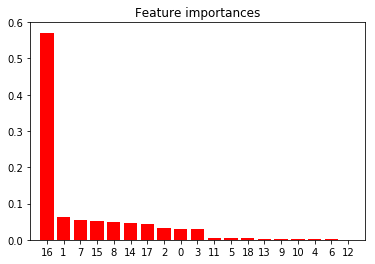

In [92]:
#feature importance
import matplotlib.pyplot as plt
col_name=X_train.columns

indices = np.argsort(features)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [87]:
print(indices)
features_indexs=[]
combinatio=dict(zip(range(0,len(col_name)),col_name))
indices=indices.tolist()
for i in range(0,len(indices)):
    a=indices.pop()
    feature=combinatio[a]
    #print(feature)
    features_indexs.append(feature)
features_indexs=features_indexs[::-1]
print(features_indexs)

[16  1  7 15  8 14 17  2  0  3 11  5 18 13  9 10  4  6 12]
['mood', 'appCat.builtin', 'appCat.other', 'circumplex.valence', 'appCat.social', 'circumplex.arousal', 'screen', 'appCat.communication', 'activity', 'appCat.entertainment', 'appCat.utilities', 'appCat.game', 'sms', 'call', 'appCat.travel', 'appCat.unknown', 'appCat.finance', 'appCat.office', 'appCat.weather']


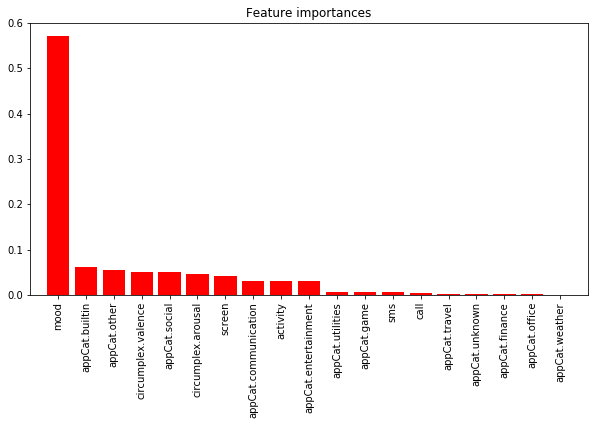

In [100]:
indices = np.argsort(features)[::-1]
#print(X_train.shape[1])
#print(len(features_indexs))
plt.figure(figsize=(10,5))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices], color="r", align="center")
plt.xticks(range(X_train.shape[1]), features_indexs,rotation='vertical')
plt.xlim([-1, X_train.shape[1]])
plt.show()

# again random forest with now feature selection

In [102]:
#3 11  5 18 13  9 10  4  6 12 are dropped
y=data.iloc[:,-1]
x=data.iloc[:,2:21]
x=x.drop(x.columns[[3, 11,  5, 18, 13,  9, 10,  4,  6, 12]],axis=1)


In [106]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
prediction, features=rfr_model(X_train, X_test, y_train, y_test)
count=0
for i in zip(y_test,prediction):
    if (i[1]-i[0])**2 < 0.25:
        count+=1
performance=count/(len(y_test)-1)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print(mean_squared_error(y_test,prediction))

C:\Users\david\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': 13, 'n_estimators': 100}
[0.08992087 0.08425621 0.08538454 0.09546822 0.07328847 0.08706202
 0.06775085 0.3323887  0.08448012]
percentage of correctly prediction: 0.6331360946745562


0.40537145945638764


### Benchmark

In [12]:
#prediction is the average mood of the previous 3 days
prediction=X_test.iloc[:,-3]
count=0
for i in zip(y_test,prediction):
    if (i[1]-i[0])**2 < 0.25:
        count+=1
performance=count/(len(y_test)-1)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print(mean_squared_error(y_test,prediction))

percentage of correctly prediction: 0.5769230769230769


0.5052804180778615


## LASSO


In [125]:
def lasso_model(X_train, X_test, y_train, y_test):
    # Perform Grid-Search
    gsc = GridSearchCV(
        estimator=linear_model.Lasso(),
        param_grid={
            'alpha': (0.0001, 0.001, 0.5, 10),   
        },
        cv=5, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)
    
    grid_result = gsc.fit(X_train, y_train)
    best_params = grid_result.best_params_
    print(best_params)
    lasso = linear_model.Lasso(alpha=best_params["alpha"])                            
    #scores = cross_val_score(rfr, X, y, cv=3, scoring='neg_mean_absolute_error')
    #predictions = cross_val_predict(rfr, X, y, cv=10)
    model=lasso.fit(X_train, y_train)
    print(lasso.coef_)
    prediction=model.predict(X_test)
    return prediction, lasso.coef_

In [126]:
from sklearn import linear_model
x=data.iloc[:,2:21]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
prediction, features=lasso_model(X_train, X_test, y_train, y_test)

count=0
for i in zip(y_test,prediction):
    if (i[1]-i[0])**2 < 0.25:
        count+=1
performance=count/(len(y_test)-1)
print("percentage of correctly prediction: " + str(performance))    
print("\n")
print("mean squared error: \n")
print(mean_squared_error(y_test,prediction))

{'alpha': 0.0001}
[ 2.46377015e-01  1.21456347e-03  6.68518512e-05  2.11741484e-04
  5.69865479e-05  6.52777162e-04  6.71903167e-04  2.64758318e-03
 -6.11354400e-04  2.10460275e-04 -1.39464808e-04  2.33915918e-03
 -4.62695604e-03  5.42384839e-02 -1.84147294e-02 -2.32507991e-01
  6.78984946e-01 -1.11495543e-04 -9.63651980e-02]
percentage of correctly prediction: 0.6568047337278107


mean squared error: 

0.3550701954620735


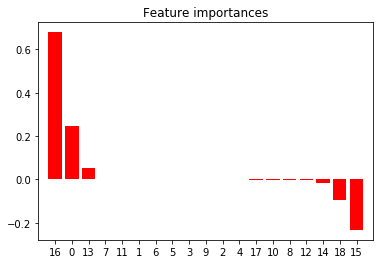

In [127]:

indices = np.argsort(features)[::-1]
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), features[indices],
       color="r", align="center")
plt.xticks(range(X_train.shape[1]), indices)
plt.xlim([-1, X_train.shape[1]])
plt.show()